In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

leggo il dataset e stampo un campione (prime 5 righe)

In [223]:
df = pd.read_csv('sms_dataset.csv', encoding="ISO-8859-1")
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5488,ham,K. I will sent it again,NaN,NaN,NaN
3628,ham,Should I head straight there or what,NaN,NaN,NaN
4302,ham,Yup i'm free...,NaN,NaN,NaN
1078,ham,Convey my regards to him,NaN,NaN,NaN
5331,ham,X course it 2yrs. Just so her messages on mess...,NaN,NaN,NaN


numero righe e colonne del dataset

In [224]:
df.shape

(5572, 5)

## Data Cleaning

stampo le info del dataset per fare una panoramica

In [225]:
df.info

<bound method DataFrame.info of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN

si può notare che ci sono delle colonne inutili (ultime 3), quindi vanno eliminate

In [226]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.sample(5)

,v1,v2
1133,ham,"As I entered my cabin my PA said, '' Happy B'd..."
3287,spam,Someone U know has asked our dating service 2 ...
3019,ham,I thank you so much for all you do with selfle...
3180,ham,So many people seems to be special at first si...
89,ham,"Ela kano.,il download, come wen ur free.."


rinomino le colonne v1 e v2 con nomi migliori

In [227]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.sample(5)

,target,text
771,ham,Lol! U drunkard! Just doing my hair at d momen...
1825,ham,Wat makes some people dearer is not just de ha...
115,ham,"As I entered my cabin my PA said, '' Happy B'd..."
5462,spam,Txt: CALL to No: 86888 & claim your reward of ...
4068,ham,Hope youåÕre not having too much fun without m...


ora devo traformare il target "ham/spam" in codifica binaria 0/1 quindi ho bisogno di sickitLearn e più nello specifico di LabelEncoder che viene utilizzato per convertire etichette categoriche in numeri interi in modo che possano essere utilizzate come input per algoritmi di machine learning. 


In [228]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [229]:
df['target'] = encoder.fit_transform(df['target'])
df.sample(5)

,target,text
2387,0,Also where's the piece
4218,0,Anything lor if they all go then i go lor...
2857,0,In life when you face choices Just toss a coin...
4601,0,\Hey j! r u feeling any better
545,0,Then any special there?


quindi ora gli spam saranno indicati come 1, gli ham come 0

controllo se sono presenti valori nulli o duplicati, e nel caso risolvo

In [230]:
df.isnull().sum()

target    0
text      0
dtype: int64

non ci sono valori nulli, procedo a verificare eventuali duplicati

In [231]:
df.duplicated().sum()

403

procedo a rimuovere i 403 duplicati

In [232]:
df = df.drop_duplicates(keep='first')

In [233]:
df.duplicated().sum()

0

ho risolto! Ora il dataset ha 0 nulli e 0 duplicati

# EDA

Vuol dire Exploratory Data Analysis (Analisi Esplorativa dei Dati) ed è una fase critica del processo di analisi dei dati nell'ambito del Machine Learning. 
Si tratta di esplorare, visualizzare e comprendere i dati prima di applicare modelli di machine learning per rivelare informazioni rilevanti, tendenze, relazioni e anomalie nei dati.

In [234]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

Quindi il mio dataset ha 4516 SMS "ham" e 653 "spam"

vado a rappresentare tale informazione usando un grafico a torta

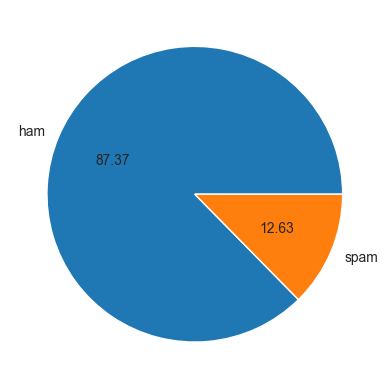

In [235]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

Quindi da tale grafico si può notare che i dati non sono bilanciati

provo a bilanciare i dati, andando a fare un clustering. Dopo aver eseguito il clustering, ed avere individuato i migliori clustering, ovvero quelli più rappresentativi grazie silhouette, vado a rimuovere un pò di dati...

In [236]:
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import silhouette_samples, silhouette_score

# Dividi il dataframe in due parti separate ham/spam
ham = df[df['target'] == 0]
spam = df[df['target'] == 1]

# Esegui il clustering dei campioni "ham" con K-Means
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))

# Calcola il valore della Silhouette per ciascun campione
sample_silhouette_values = silhouette_samples(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Calcola la Silhouette Score media per tutti i campioni nella classe "ham"
silhouette_avg = silhouette_score(ham['text'].str.len().values.reshape(-1, 1), ham['cluster'])

# Trova i cluster con Silhouette Score più alti
best_clusters = []
for cluster_id in range(num_clusters):
    cluster_silhouette_values = sample_silhouette_values[ham['cluster'] == cluster_id]
    avg_silhouette = np.mean(cluster_silhouette_values)
    best_clusters.append((cluster_id, avg_silhouette))

# Ordina i cluster in base alla Silhouette Score in ordine decrescente
best_clusters = sorted(best_clusters, key=lambda x: x[1], reverse=True)

# Scegli i primi cluster (i migliori) come cluster rappresentativi
representative_clusters = [cluster[0] for cluster in best_clusters[:2]]  # Esempio: scegli i primi due cluster migliori

# Esegui l'undersampling dai cluster rappresentativi
undersampled_ham = pd.DataFrame()

num_samples_per_cluster = 250  # Numero di campioni da campionare da ciascun cluster rappresentativo

for cluster_id in representative_clusters:
    cluster_samples = ham[ham['cluster'] == cluster_id]
    
    # Esegui l'undersampling (campiona da ciascun cluster rappresentativo)
    cluster_samples = resample(cluster_samples, replace=False, n_samples=num_samples_per_cluster, random_state=42)
    
    # Aggiungi i campioni campionati all'insieme di campioni sottocampionati
    undersampled_ham = pd.concat([undersampled_ham, cluster_samples])

# Combina l'undersampled classe "ham" con la classe "spam" per ottenere il dataset bilanciato
df_undersampled = pd.concat([undersampled_ham, spam])

# Ora df_undersampled contiene il dataset bilanciato, quindi copio in variabile df 

df = df_undersampled


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/zq/qftd43l52j55ztwn7drwlhl40000gn/T/ipykernel_4039/4252129279.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ham['cluster'] = kmeans.fit_predict(ham['text'].str.len().values.reshape(-1, 1))


Ora ho effettuato l'undersampling del dataset, rimuovendo 1000 righe, ristampo un grafico a tornta per vedere il bilanciamento.

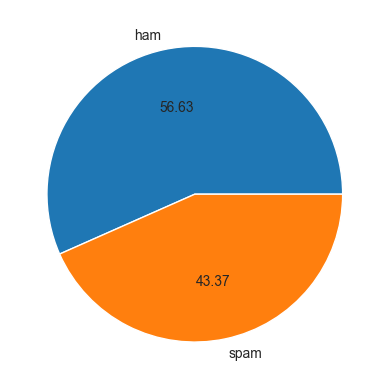

In [237]:
plt.pie(df['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f")
plt.show()

ora posso andare copiare tutto su df, eliminando la colonna cluster dato che non mi servirà più

In [238]:
df = df_undersampled.drop(columns=['cluster'])
df.sample(5)

,target,text
3854,1,Free msg: Single? Find a partner in your area!...
2249,1,"Thanks for your ringtone order, ref number R83..."
2641,1,"You are guaranteed the latest Nokia Phone, a 4..."
3332,1,You are being contacted by our dating service ...
1856,0,"Say this slowly.? GOD,I LOVE YOU &amp; I NEED ..."


In [239]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samuelerusso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ho scaricato la libreria Nltk Python ampiamente utilizzata per il trattamento del linguaggio naturale. Tra gli strumenti presenti, c'è il tokenizer NLTK denominato "Punkt" che viene utilizzato per la suddivisione di testo in frasi ed è molto utile quando si desidera suddividere un testo in frasi al fine di analizzarle o elaborarle in modo più dettagliato.

ora vado a vedere la lungehzza in caratteri di ogni messaggio 

In [240]:
df['text'].apply(len) 


5107     57
5341     38
2019     38
4981     57
2830     26
       ... 
5537     90
5540    160
5547    160
5566    147
5567    161
Name: text, Length: 1153, dtype: int64

quindi creo una nuova colonna nel dataset in cui indico il numero di caratteri e stampo un sample per vedere che tutto ha funzionato

In [241]:
df['num_characters'] = df['text'].apply(len)
df.head()

,target,text,num_characters
5107,0,I REALLY NEED 2 KISS U I MISS U MY BABY FROM U...,57
5341,0,And of course you should make a stink!,38
2019,0,From tomorrow onwards eve 6 to 3 work.,38
4981,0,Slept? I thinkThis time ( &lt;#&gt; pm) is no...,57
2830,0,Thanx 4 sending me home...,26


vado ora a calcolare il numero di parole in ogni messaggio, utilizzando il tokenizer della libreria nltk. Vado anche qui a creare una colonna.

In [242]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_characters,num_words
5107,0,I REALLY NEED 2 KISS U I MISS U MY BABY FROM U...,57,15
5341,0,And of course you should make a stink!,38,9
2019,0,From tomorrow onwards eve 6 to 3 work.,38,9
4981,0,Slept? I thinkThis time ( &lt;#&gt; pm) is no...,57,18
2830,0,Thanx 4 sending me home...,26,6


vado ora a calcolare il numero di frasi per ogni messaggio e metto i dati in una nuova colonna

In [243]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_characters,num_words,num_sentences
5107,0,I REALLY NEED 2 KISS U I MISS U MY BABY FROM U...,57,15,1
5341,0,And of course you should make a stink!,38,9,1
2019,0,From tomorrow onwards eve 6 to 3 work.,38,9,1
4981,0,Slept? I thinkThis time ( &lt;#&gt; pm) is no...,57,18,2
2830,0,Thanx 4 sending me home...,26,6,1


stampo un grafico che mi faccia vedere le differenze di caratteri tra sms ham/spam.

<Axes: xlabel='num_characters', ylabel='Count'>

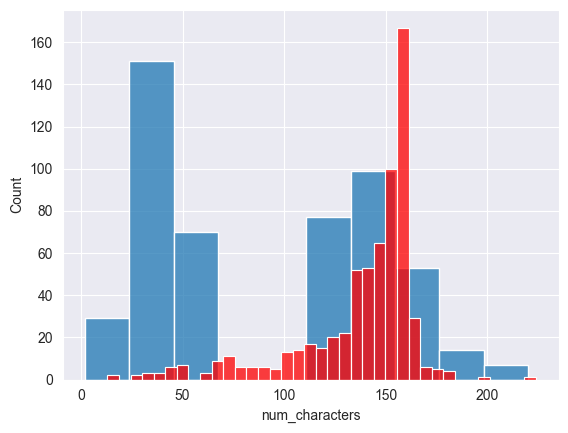

In [244]:
import seaborn as sns
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target']==1]['num_characters'], color='red')


Quindi si può notare che i messaggi spam hanno molti più caratteri in media

Ora vado a stampare lo stesso tipo di grafico, ma per il numero di parole.

<Axes: xlabel='num_words', ylabel='Count'>

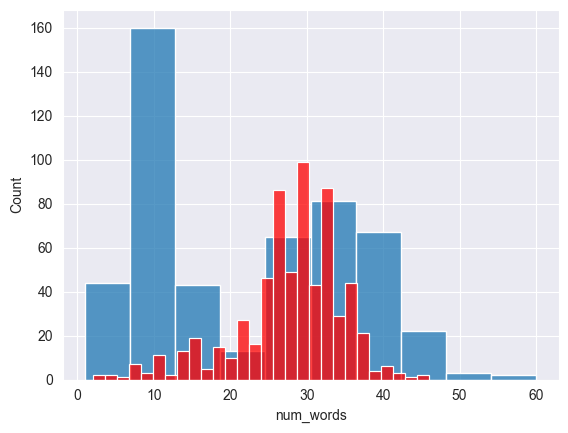

In [245]:
sns.histplot(df[df['target']==0]['num_words'])
sns.histplot(df[df['target']==1]['num_words'], color='red')

come si può notare da tale grafico, i messaggi spam hanno decisamente più parole.

ora stampo un grafico riassuntivo, un pairplot, che consente di esplorare le relazioni tra diverse variabili all'interno di un dataset.

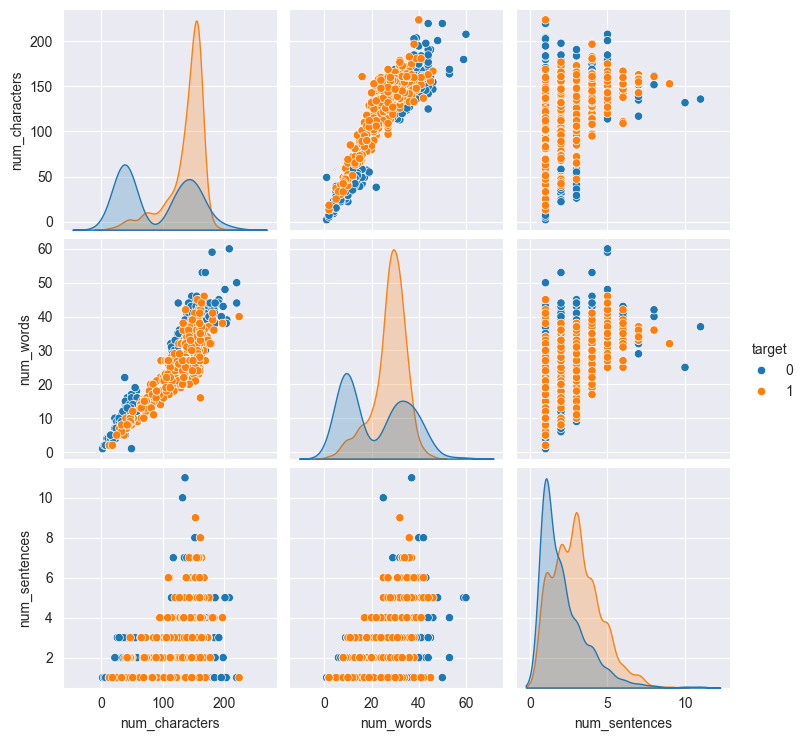

In [246]:
sns.pairplot(df, hue='target')

vado ora a stampare la matrice di correlazione, che mi restituisce le correlazioni tra le variabili del dataset, prima di fare ciò devo escludere dal dataframe la colonna text

In [247]:
df_without_text = df.drop(columns=["text"])
df_without_text.corr()

,target,num_characters,num_words,num_sentences
target,1.000000,0.467727,0.263311,0.277204
num_characters,0.467727,1.000000,0.922995,0.476585
num_words,0.263311,0.922995,1.000000,0.527272
num_sentences,0.277204,0.476585,0.527272,1.000000


vado a rappresentare tali valori con una heatmap che utilizza colori per visualizzare i valori dei coefficienti di correlazione tra le diverse coppie di variabili nel dataset, consentendo di individuare facilmente relazioni tra di esse.
Le celle più scure o più chiare indicano correlazioni più forti o più deboli, rispettivamente. 
Puoi identificare le variabili che sono fortemente correlate tra loro (valori vicini a 1 o -1) o variabili che hanno una bassa correlazione (valori vicini a 0).

<Axes: >

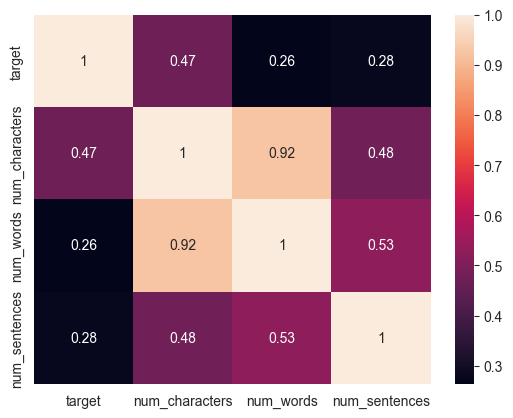

In [248]:
sns.heatmap(df_without_text.corr(), annot=True)